1 - Importing the needed libraries and modules.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import re
import math
from collections import Counter
from urllib.parse import urlparse

2 - I've noticed the model is not predicting accurately when the url has a legit domain with a login or sign in or verification path, so i decided to add examples of this casw to improve the model's accuracy. 

In [13]:
with open(r"C:\Users\pc\Desktop\final\added_urls.txt", "r") as f:
    new_legit_urls = [line.strip() for line in f if line.strip()]
new_data = pd.DataFrame({
    "url": new_legit_urls,
    "type": ["legitimate"] * len(new_legit_urls)
})

3- Loading the data in the dataframe after balancing it. I used the Mendeley dataset that has a lot more legitimate urls than phishing ones so i took a subset of the legitimate urls to match the size of the phishing set thus creating a balanced set.

In [14]:
data = pd.read_csv(r"C:\Users\pc\Desktop\final\URL dataset.csv")
phish = data[data['type'] == 'phishing']
legit = data[data['type'] == 'legitimate'].sample(n=len(phish), random_state=42)

# Combine into balanced dataset
balanced_data = pd.concat([phish, legit]).sample(frac=1, random_state=42).reset_index(drop=True)
balanced_data = pd.concat([balanced_data, new_data], ignore_index=True)

4 - Plotting the distribution of phishing and legitimate urls.

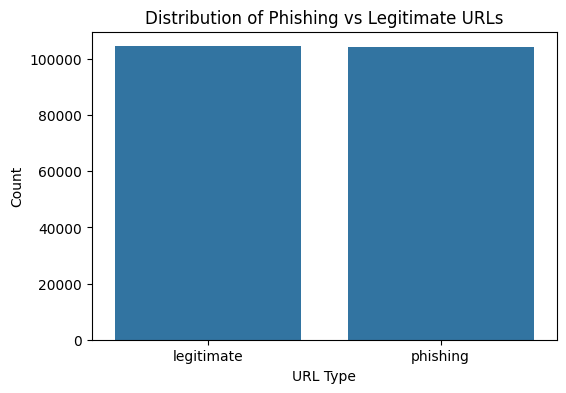

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(data=balanced_data, x="type")
plt.title("Distribution of Phishing vs Legitimate URLs")
plt.xlabel("URL Type")
plt.ylabel("Count")
plt.show()

5 - Function to extract features from the dataset's urls with three helper functions.

In [16]:

def has_brand_name(url, brands=["paypal", "google", "facebook", "github"]):
    return int(any(brand in url.lower() for brand in brands))

def weighted_suspicious_word(url):
    parsed = urlparse(url)
    domain_part = parsed.netloc.lower()
    path_part = parsed.path.lower()
    suspicious_words = ["secure", "account", "update", "verify", "bank"]
    
    
    for word in suspicious_words:
        if word in domain_part:
            return 1
        if word in path_part:
            return 0.5
    return 0


BRAND_NAMES = [
    "paypal", "bankofamerica", "github", "google", "facebook", 
    "linkedin", "instagram", "twitter", "amazon", "netflix", "coinbase", "binance"
]

# List of suspicious words often used in phishing URLs
SUSPICIOUS_WORDS = [
    "secure", "account", "update", "login", "verify", "signin", "webscr", "confirm", "alert"
]

def entropy(s):
    """Calculate Shannon entropy of a string."""
    prob = [float(s.count(c)) / len(s) for c in set(s)]
    return -sum([p * math.log2(p) for p in prob]) if prob else 0

def extract_features(url, weight_https=0.7):
    """
    Extracts features from a URL for phishing detection.
    weight_https: factor to down-weight is_https feature
    """
    try:
        parsed = urlparse(url)
        domain = parsed.netloc.lower()
        path = parsed.path
        
        # Main domain: last two parts of domain
        parts = domain.split('.')
        if len(parts) >= 2:
            main_domain = parts[-2] + '.' + parts[-1]
        else:
            main_domain = domain
        
        # Subdomain: everything before main domain
        subdomain = domain.replace('.' + main_domain, '')
        
        features = {}
        
        # Basic URL properties
        features["url_length"] = len(url)
        features["num_dots"] = url.count(".")
        features["num_hyphens"] = url.count("-")
        features["has_at_symbol"] = 1 if "@" in url else 0
        features["has_ip"] = 1 if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', domain) else 0
        features["num_subdomains"] = subdomain.count(".")
        features["is_https"] = 1 if parsed.scheme == "https" else 0
        features["num_query_params"] = len(parsed.query.split("&")) if parsed.query else 0
        features["path_length"] = len(path)
        features["num_path_segments"] = len(path.split("/")) - 1 if path else 0
        features["entropy"] = entropy(url)
        
        # Suspicious word feature
        features["has_suspicious_word"] = int(any(word in url.lower() for word in SUSPICIOUS_WORDS))
        
        # Brand-safe / suspicious brand feature
        # 1 if a known brand is in subdomain but not in main domain → suspicious
        brand_flag = 0
        for brand in BRAND_NAMES:
            if brand in domain:
                if brand not in main_domain:
                    brand_flag = 1  # suspicious
        features["has_brand_name_suspicious"] = brand_flag
        
        # Down-weight HTTPS
        features["is_https"] *= weight_https
        
        return features
    except:
        return None

6 - Splitting the data into train/test sets and training the model using random forest.

In [17]:
feature_list = []
labels = []

for idx, row in balanced_data.iterrows():
    f = extract_features(row["url"])
    if f is not None:
        feature_list.append(f)
        labels.append(row["type"])  # keep label

X = pd.DataFrame(feature_list)
y = pd.Series(labels)
X['is_https'] = X['is_https'] * 0.5 # I had to weight down the is_https feature by 50% because my model was highly dependent on it
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  legitimate       0.98      0.99      0.99     20900
    phishing       0.99      0.98      0.99     20888

    accuracy                           0.99     41788
   macro avg       0.99      0.99      0.99     41788
weighted avg       0.99      0.99      0.99     41788



7 - Visulazing predictions vs true lables through a confusion matrix.

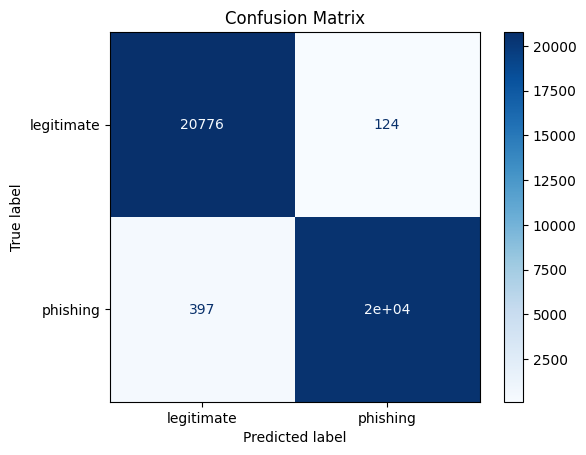

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

7 - Plotting the feature correlation heatmap.

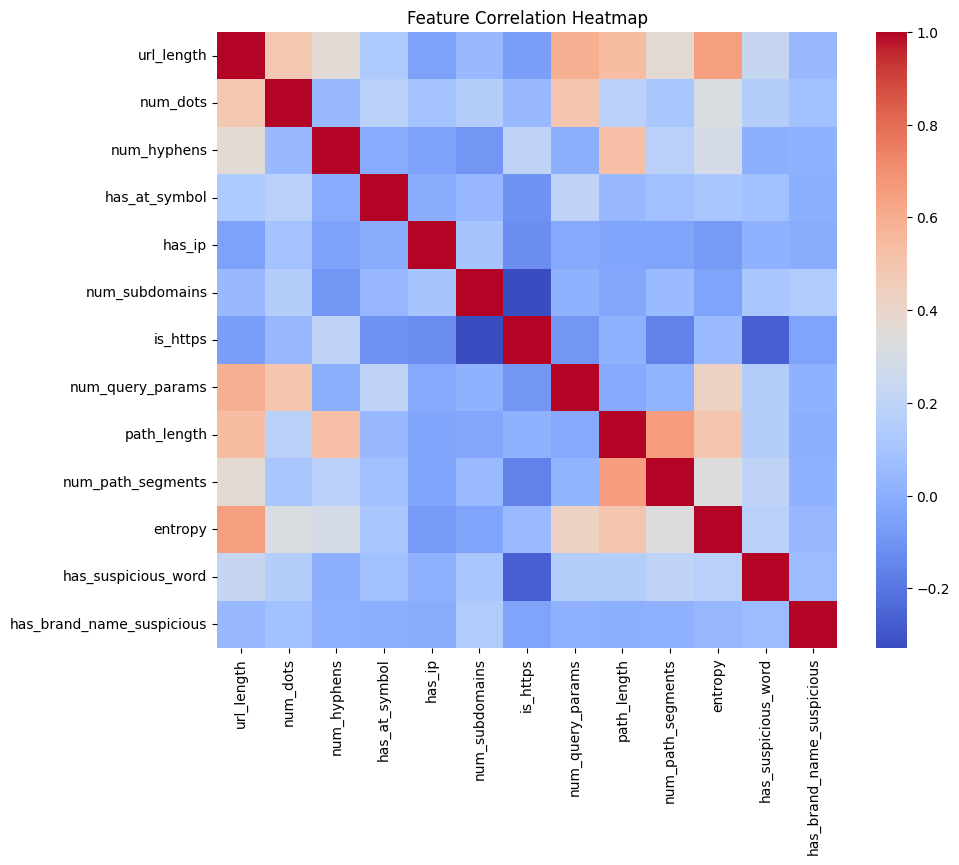

In [20]:
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), annot=False, cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

8- A plot that shows the most important features.

C:\Users\pc\AppData\Local\Temp\ipykernel_8932\4232229568.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x='importance', y='feature', palette="viridis")


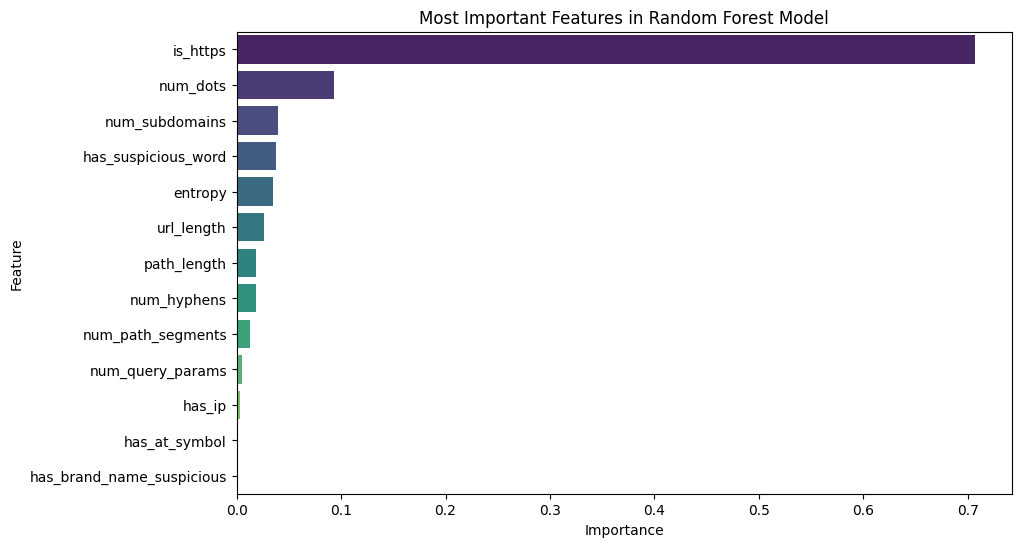

In [18]:
importances = model.feature_importances_
feature_names = X.columns

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp, x='importance', y='feature', palette="viridis")
plt.title("Most Important Features in Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

9 - Saving the model to be used without retraining.

In [19]:
joblib.dump(model, "phishing_url_model.pkl")

['phishing_url_model.pkl']